# TO RUN
1. Make sure you installed all the dependencies
2. open **'init_notebook.py'** and change the **projectFolder** to the src folder of the repository.
3. In the following cell change the dataDir to the data directory of the InD dataset

In [1]:
dataDir = "/home/ababil/BUET/AV/location-2"
# dataDir = "C:/Users/Zenbook325E/Downloads/csv"
# dataDir = "D:/AV/DataSetExploration/drone-dataset-tools/data/location-2"

In [2]:
exec(open('init_notebook.py').read())

current working dir/home/ababil/BUET/AV/Behavior Hypotheses/behavior-hypotheses/src


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from behavior_tools.TrajectoryADECalculator import TrajectoryADECalculator
from behavior_tools.Sampler import Sampler
from tti_dataset_tools.ColMapper import ColMapper

from behavior_tools.AngularDisplacementCalculator import AngularDisplacementCalculator

In [5]:
sceneId = 210
date = "2023-05-04"
fps=10
minYDisplacement = 5
maxXDisplacement = 6
pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
otherDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))

In [6]:
visualizer = TrajectoryVisualizer()
adeCalculator = TrajectoryADECalculator()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity',
        xAccCol='sceneXAcceleration',
        yAccCol='sceneYAcceleration',
        speedCol='speed',
        accelerationCol='acceleration',
    )
transformer = TrajectoryTransformer(colMapper)
cleaner = TrajectoryCleaner(
    colMapper = colMapper,
    minSpeed = 0.0, # we can consider them as obstacles
    maxSpeed = 3.5,
    minAcceleration = 0.0,
    maxAcceleration = 2.0,   
    minYDisplacement = minYDisplacement,
    maxXDisplacement = maxXDisplacement
)
transformer.deriveSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
transformer.deriveAcceleration(pedDf)
# plt.boxplot(pedDf['displacementY'])
# plt.show()
# plt.boxplot(pedDf['speed'])
# plt.show()
# plt.boxplot(pedDf['acceleration'])
# plt.show()

In [7]:
cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)

# visualizer.show(pedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
# visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
transformer.translateAllToLocalSource(cleanPedDf)

southIds = []
for pedId in allPedIds:
    trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
    trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
    # print(trackMeta['verticalDirection'])
    if trackMeta['verticalDirection'] == "SOUTH":
        southIds.append(pedId)
        # print(trackMeta["uniqueTrackId"])
        X, Y = transformer.rotate(trackDf)
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
len(cleanPedDf)


using min Y displacement (5)


7600

### Right side of the vertical axis is negative

In [8]:

startingDf = cleanPedDf[cleanPedDf["displacementY"] < 1].copy()
midDf = cleanPedDf[(cleanPedDf["displacementY"] >= 1) & (cleanPedDf["displacementY"] < 4)].copy()
endDf = cleanPedDf[(cleanPedDf["displacementY"] >= 4)].copy()
startingDf.head(10)

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,0.021570,-0.040735,0.487023
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,0.034821,-0.050307,0.584184
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,0.025032,-0.060815,0.681701
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,0.028268,-0.071832,0.780228
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,0.018896,-0.083028,0.879489


In [9]:
# plt.boxplot(startingDf["speed"])

In [10]:
# get the pedestrians who started at almost 0 speed.
# get pedestrians who started at almost the median speed.
medianStartingSpeed = startingDf["speed"].median()
medianStartingVelocityDf = startingDf[abs(startingDf["speed"] - medianStartingSpeed) < 0.005].copy()
medianStartingVelocityPedIds = list(medianStartingVelocityDf["uniqueTrackId"].unique())
# medianStartingVelocityPedIds

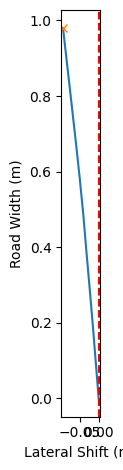

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,0.021570,-0.040735,0.487023
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,0.034821,-0.050307,0.584184
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,0.025032,-0.060815,0.681701
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,0.028268,-0.071832,0.780228
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,0.018896,-0.083028,0.879489


In [11]:
starting023 = startingDf[startingDf["uniqueTrackId"] == 18023].copy()
visualizer.show(starting023, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
# starting023.size
starting023

In [12]:
starting023 = AngularDisplacementCalculator.addAngularDisplacement(starting023)
starting023 = AngularDisplacementCalculator.addRelativeAngularDisplacement(starting023)
starting023

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,angularDisplacement,relativeAngularDisplacement
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000,0.000000,0.000000
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163,4.602626,4.602626
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480,4.586357,-0.016269
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789,4.685391,0.099034
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772,4.774086,0.088696
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,0.021570,-0.040735,0.487023,4.781115,0.007028
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,0.034821,-0.050307,0.584184,4.921881,0.140766
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,0.025032,-0.060815,0.681701,5.097927,0.176046
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,0.028268,-0.071832,0.780228,5.260147,0.162220
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,0.018896,-0.083028,0.879489,5.393035,0.132888


In [16]:
newAngularDisplacementDf = AngularDisplacementCalculator.getPedAngularDisplacementDf(startingDf)
newAngularDisplacementDf

,uniqueTrackId,count,maxAngularDisplacement,meanAbsoluteAngularDisplacement,meanAngularDisplacement,maxRelativeAngularDisplacement,meanAbsoluteRelativeAngularDisplacement,meanRelativeAngularDisplacement,maxSpeed,meanSpeed
0,18023,11,5.499709,4.509298,4.509298,4.602626,0.502932,0.499974,0.499737,0.490995
1,18069,9,17.109814,13.187375,13.187375,17.109814,2.329281,1.472900,0.648834,0.631765
2,18090,7,3.923593,3.052550,-3.052550,3.379978,0.561510,-0.560513,0.802478,0.786039
3,18121,9,15.576390,12.877389,12.877389,15.576390,1.987264,1.474156,0.618203,0.609641
4,18134,12,2.171162,0.981100,0.139779,1.304632,0.398369,0.180930,0.479898,0.466251
...,...,...,...,...,...,...,...,...,...,...
163,29353,9,5.658133,4.871808,4.871808,5.373167,0.628681,0.628681,0.603601,0.590958
164,29439,5,15.828122,12.541011,12.541011,15.828122,3.227915,3.103334,1.065763,1.055135
165,29498,7,1.927890,1.395051,1.395051,1.927890,0.353450,0.197376,0.761582,0.742835
166,29530,9,33.997339,29.833908,-29.833908,33.997339,3.881417,-3.703951,0.681933,0.667583


In [22]:
NO_OF_CATEGORY = 3

def assign_category(value_column, num_categories):
    min_value = value_column.min()
    max_value = value_column.max()
    value_range = max_value - min_value
    category_range = value_range / num_categories
    
    def categorize(speed):
        category = int((speed - min_value) / category_range)
        return min(category, num_categories - 1)
    
    categories = value_column.apply(categorize)
    return categories

In [25]:
newAngularDisplacementDf.columns

Index(['uniqueTrackId', 'count', 'maxAngularDisplacement',
       'meanAbsoluteAngularDisplacement', 'meanAngularDisplacement',
       'maxRelativeAngularDisplacement',
       'meanAbsoluteRelativeAngularDisplacement',
       'meanRelativeAngularDisplacement', 'maxSpeed', 'meanSpeed'],
      dtype='object')

In [27]:
col1 = 'maxRelativeAngularDisplacement'
col2 = 'maxSpeed'

newAngularDisplacementDf['category1'] = assign_category(newAngularDisplacementDf[col1], NO_OF_CATEGORY)
newAngularDisplacementDf['category2'] = assign_category(newAngularDisplacementDf[col2], NO_OF_CATEGORY)

newAngularDisplacementDf

,uniqueTrackId,count,maxAngularDisplacement,meanAbsoluteAngularDisplacement,meanAngularDisplacement,maxRelativeAngularDisplacement,meanAbsoluteRelativeAngularDisplacement,meanRelativeAngularDisplacement,maxSpeed,meanSpeed,category1,category2
0,18023,11,5.499709,4.509298,4.509298,4.602626,0.502932,0.499974,0.499737,0.490995,0,0
1,18069,9,17.109814,13.187375,13.187375,17.109814,2.329281,1.472900,0.648834,0.631765,1,1
2,18090,7,3.923593,3.052550,-3.052550,3.379978,0.561510,-0.560513,0.802478,0.786039,0,1
3,18121,9,15.576390,12.877389,12.877389,15.576390,1.987264,1.474156,0.618203,0.609641,1,0
4,18134,12,2.171162,0.981100,0.139779,1.304632,0.398369,0.180930,0.479898,0.466251,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
163,29353,9,5.658133,4.871808,4.871808,5.373167,0.628681,0.628681,0.603601,0.590958,0,0
164,29439,5,15.828122,12.541011,12.541011,15.828122,3.227915,3.103334,1.065763,1.055135,1,2
165,29498,7,1.927890,1.395051,1.395051,1.927890,0.353450,0.197376,0.761582,0.742835,0,1
166,29530,9,33.997339,29.833908,-29.833908,33.997339,3.881417,-3.703951,0.681933,0.667583,2,1


In [28]:
# prepare a heatmap on the categories
heatmapDf = pd.DataFrame(columns = ['category1', 'category2', 'count'])
heatmapDf['category1'] = newAngularDisplacementDf['category1']
heatmapDf['category2'] = newAngularDisplacementDf['category2']
heatmapDf['count'] = 1
heatmapDf = heatmapDf.groupby(['category1', 'category2']).count().reset_index()
heatmapDf

,category1,category2,count
0,0,0,45
1,0,1,31
2,0,2,1
3,1,0,32
4,1,1,37
5,1,2,4
6,2,0,10
7,2,1,8


In [29]:
heatmapDf = heatmapDf.pivot(index='category1', columns='category2', values='count')
heatmapDf

category2,0,1,2
category1,,,
0,45.0,31.0,1.0
1,32.0,37.0,4.0
2,10.0,8.0,NaN
